# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Pomocnicze funkcje

## Wykresy

### Rysowanie wykresu funkcji

In [3]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn)(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()

# Zadanie 1

## Badana funkcja

$f(x) = x^n - (1-x)^m$

$n=10$, $m=15$, $x \in [-0.5, 1]$

Stąd, po podstawieniu, otrzymujemy:

$f(x) = x^{10} - (1-x)^{15}$

In [4]:
n = 10
m = 15
a = -.5
b = 1

f = lambda x: x**n - (1 - x)**m

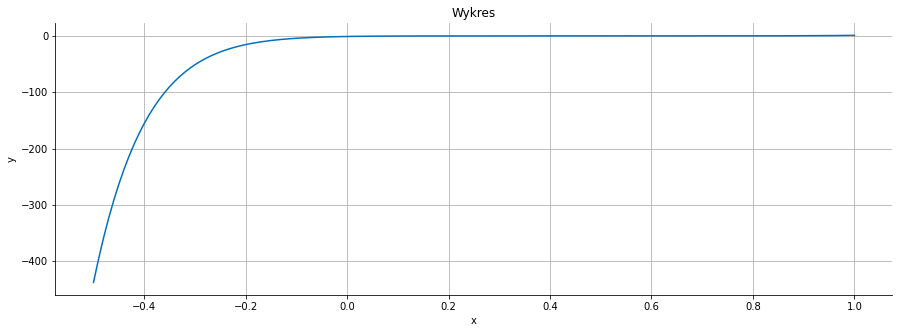

In [5]:
plt.figure(figsize=(15, 5))
plot_fn(f, a, b, step=.01, color='#0070c0')

## Porównywanie liczby iteracji

Do porównania liczby iteracji dla metody Newtona oraz metody siecznych, wykorzystam poniższe kryteria stopu.

### Zastosowane kryteria stopu

#### 1. Kryterium

$|x_{(i+i)} - x_{(i)}| \lt \rho$

In [6]:
stop_criterion_init1 = lambda 𝜌: lambda _, x_prev, x_curr: abs(x_curr - x_prev) < 𝜌

#### 2. Kryterium

$|f(x_i)| \lt \rho$

In [6]:
stop_criterion_init2 = lambda 𝜌: lambda f, _, x_curr: abs(f(x_curr)) < 𝜌

# Zastosowane metody wyznaczania pierwiastków równania

## Metoda Newtona-Raphsona

Korzystamy ze wzoru iteracyjnego:

$\phi(x) = x - \frac{f(x)}{f'(x)}$

In [7]:
𝜙_init = lambda f, deriv_f: lambda x: x - f(x) / deriv_f(x)

Potrzebujemy 1. pochodnej funkcji. Możemy ją wyliczyć "ręcznie", a następnie zapisać jako funkcję. Otrzymujemy:

$f(x) = n \cdot x^{(n - 1)} + m \cdot (1-x)^{(m - 1)}$

In [26]:
f_deriv = lambda x: n * x ** (n - 1) + m * (1 - x) ** (m - 1)

### Implementacja

In [8]:
def newton_raphson(f, f_deriv, x0, stop_criterion):
    x_prev = float('inf')
    x_curr = x0
    𝜙 = 𝜙_init(f, f_deriv)
    iters = 0
    
    while not stop_criterion(f, x_prev, x_curr):
        x_curr, x_prev = 𝜙(x_curr), x_curr
        iters += 1
        
    return x_curr, iters

### Badanie funkcji

#### Przykłady

In [9]:
𝜌 = .000000000000001
newton_raphson(f, f_deriv, a, stop_criterion_init1(𝜌))

NameError: name 'f_deriv' is not defined

In [29]:
𝜌 = .000000000000001
newton_raphson(f, f_deriv, a, stop_criterion_init2(𝜌))

(0.4301597090019467, 18)

#### Wyznaczanie liczby iteracji oraz wyników dla różnych punktów startowych

##### Pomocnicza funkcja

In [46]:
def calculate(a, b, stop_criterion_init, 𝜌_list, step=.1):
    n = int(abs(b - a) / step + .5)
    x0_list = [a + step * i for i in range(n)] + [b]
    stop_criterions = list(map(stop_criterion_init, 𝜌_list))
    
    df = pd.DataFrame(columns=𝜌_list, index=x0_list)
    
    for i, x0 in enumerate(x0_list):
        for j, 𝜌 in enumerate(𝜌_list):
            df.iloc[i, j] = newton_raphson(f, f_deriv, x0, stop_criterions[j])
            
    return df

##### Rezultaty dla kryterium 1.

Kolejne punkty startowe były wyznaczane na przedziale $[a, b] = [-0.5, 1]$ z krokiem $0.1$.

In [53]:
df1 = calculate(a, b, stop_criterion_init1, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [54]:
df1.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,0.430159,0.430159,0.43016,0.43016,0.43016,0.43016,0.43016
-0.4,0.430159,0.430159,0.43016,0.43016,0.43016,0.43016,0.43016
-0.3,0.429888,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
-0.2,0.430049,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
-0.1,0.430140,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.0,0.430159,0.430159,0.43016,0.43016,0.43016,0.43016,0.43016
0.1,0.430122,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.2,0.429937,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.3,0.429847,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.4,0.430107,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016


###### Liczby iteracji

In [55]:
df1.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,16,16,17,17,18,18,19
-0.4,15,15,16,16,17,17,18
-0.3,13,14,15,15,16,16,17
-0.2,12,13,14,14,14,15,15
-0.1,11,12,12,13,13,14,14
0.0,10,10,11,11,12,12,13
0.1,8,9,9,10,10,11,11
0.2,6,7,8,8,8,9,10
0.3,4,5,6,6,7,7,8
0.4,2,3,3,4,4,5,5


##### Rezultaty dla kryterium 2.

In [62]:
df2 = calculate(a, b, stop_criterion_init2, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [63]:
df2.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,0.297734,0.386835,0.429762,0.429762,0.430159,0.43016,0.43016
-0.4,0.297734,0.386835,0.429762,0.429762,0.430159,0.43016,0.43016
-0.3,0.301314,0.389712,0.429888,0.429888,0.430160,0.43016,0.43016
-0.2,0.308985,0.395736,0.423644,0.430049,0.430160,0.43016,0.43016
-0.1,0.272866,0.404871,0.427072,0.430140,0.430160,0.43016,0.43016
0.0,0.291748,0.381951,0.429446,0.429446,0.430159,0.43016,0.43016
0.1,0.268265,0.401783,0.426065,0.430122,0.430160,0.43016,0.43016
0.2,0.303098,0.391131,0.421422,0.429937,0.430160,0.43016,0.43016
0.3,0.300000,0.388660,0.429847,0.429847,0.430160,0.43016,0.43016
0.4,0.400000,0.400000,0.425412,0.430107,0.430160,0.43016,0.43016


###### Liczby iteracji

In [64]:
df2.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,11,13,15,15,16,17,18
-0.4,10,12,14,14,15,16,17
-0.3,9,11,13,13,14,15,15
-0.2,8,10,11,12,13,14,14
-0.1,6,9,10,11,12,12,13
0.0,5,7,9,9,10,11,12
0.1,3,6,7,8,9,9,10
0.2,2,4,5,6,7,8,8
0.3,0,2,4,4,5,6,6
0.4,0,0,1,2,3,3,4


## Metoda siecznych

Korzystamy ze wzoru iteracyjnego:

$\Large{x_{i+2} = x_{i+1} - \frac{x_{i+1} - x_i}{f(x_{i+1}) - f(x_i)} \cdot f(x_{i + 1})}$

### Implementacja

In [96]:
def calc_xi2(f, xi0, xi1):
    return xi1 - (xi1 - xi0) / (f(xi1) - f(xi0)) * f(xi1)

def secant_method(f, x0, x1, stop_criterion):
    xi0 = None
    xi1 = x0
    xi2 = x1
    iters = 0
    
    while not stop_criterion(f, xi1, xi2):
        xi2, xi1, xi0 = calc_xi2(f, xi2, xi1), xi2, xi1
        iters += 1
        
    return xi2, iters

### Badanie funkcji

#### Przykłady

In [97]:
𝜌 = .000000000000001
secant_method(f, -.5, -.4, stop_criterion_init1(𝜌))

(0.4301597090019468, 25)

In [98]:
𝜌 = .000000000000001
secant_method(f, b, a, stop_criterion_init1(𝜌))

(0.4301597090019468, 19)

#### Wyznaczanie liczby iteracji oraz wyników dla różnych punktów startowych

##### Pomocnicza funkcja

In [89]:
def calculate(a, b, x1, stop_criterion_init, 𝜌_list, step=.1):
    if not a <= x1 <= b:
        raise Exception(f'x1={x1} is not between {a} and {b}')
        
    if x1 - a < b - x1:
        a = x1
    else:
        b = x1
    
    n = int(abs(b - a) / step + .5)
    if a == x1:
        x0_list = [a + step * i for i in range(1, n)] + [b]
    else:
        x0_list = [a + step * i for i in range(n)]
        
    stop_criterions = list(map(stop_criterion_init, 𝜌_list))
    dec_places = len(str(int(1 / step + .5)))
    
    df = pd.DataFrame(columns=𝜌_list, index=[(round(min(x0, x1), dec_places), round(max(x0, x1), dec_places)) for x0 in x0_list])
    
    for i, x0 in enumerate(x0_list):
        for j, 𝜌 in enumerate(𝜌_list):
            df.iloc[i, j] = secant_method(f, x0, x1, stop_criterions[j])
            
    return df

##### Rezultaty dla kryterium 1.

In [99]:
df1 = calculate(a, b, a, stop_criterion_init1, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki - FIXME - chyba wyniki nie powinny wychodzić poza przedział startowy

In [101]:
df1.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",0.430050,0.430159,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, -0.3)",0.430041,0.430159,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, -0.2)",-0.179222,0.430160,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, -0.1)",-0.092459,0.430159,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.0)",0.002272,0.430158,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.1)",0.100563,0.100563,0.430159,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.2)",0.200112,0.200112,0.200112,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.3)",0.300017,0.300017,0.300017,0.300017,0.43016,0.43016,0.43016
"(-0.5, 0.4)",0.400002,0.400002,0.400002,0.400002,0.43016,0.43016,0.43016
"(-0.5, 0.5)",0.499996,0.499996,0.499996,0.499996,0.43016,0.43016,0.43016


##### Liczby iteracji

In [103]:
df1.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",21,22,23,23,24,24,25
"(-0.5, -0.3)",20,21,22,22,23,24,24
"(-0.5, -0.2)",2,20,20,21,21,22,23
"(-0.5, -0.1)",2,18,19,19,20,21,21
"(-0.5, 0.0)",2,16,17,17,18,19,19
"(-0.5, 0.1)",2,2,14,15,16,16,17
"(-0.5, 0.2)",2,2,2,13,13,14,15
"(-0.5, 0.3)",2,2,2,2,10,11,12
"(-0.5, 0.4)",2,2,2,2,7,8,9
"(-0.5, 0.5)",2,2,2,2,8,9,9


##### Rezultaty dla kryterium 2.

In [105]:
df2 = calculate(a, b, a, stop_criterion_init2, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [106]:
df2.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",0.267755,0.393200,0.427556,0.430050,0.430159,0.43016,0.43016
"(-0.5, -0.3)",0.267074,0.392693,0.427437,0.430041,0.430159,0.43016,0.43016
"(-0.5, -0.2)",0.278183,0.373942,0.428949,0.430131,0.430160,0.43016,0.43016
"(-0.5, -0.1)",0.265504,0.391525,0.427147,0.430018,0.430159,0.43016,0.43016
"(-0.5, 0.0)",0.296936,0.389253,0.426531,0.429962,0.430158,0.43016,0.43016
"(-0.5, 0.1)",0.268407,0.393852,0.427706,0.430061,0.430159,0.43016,0.43016
"(-0.5, 0.2)",0.282801,0.379149,0.422878,0.429447,0.430160,0.43016,0.43016
"(-0.5, 0.3)",0.300009,0.371762,0.428857,0.430127,0.430160,0.43016,0.43016
"(-0.5, 0.4)",0.400001,0.400001,0.425413,0.429586,0.430154,0.43016,0.43016
"(-0.5, 0.5)",0.499998,0.499998,0.436683,0.430268,0.430159,0.43016,0.43016


###### Liczby iteracji

In [107]:
df2.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",14,18,20,21,22,23,24
"(-0.5, -0.3)",13,17,19,20,21,22,23
"(-0.5, -0.2)",12,15,18,19,20,21,22
"(-0.5, -0.1)",10,14,16,17,18,19,20
"(-0.5, 0.0)",9,12,14,15,16,17,18
"(-0.5, 0.1)",6,10,12,13,14,15,16
"(-0.5, 0.2)",4,7,9,10,12,13,14
"(-0.5, 0.3)",1,4,7,8,9,10,11
"(-0.5, 0.4)",1,1,3,4,5,6,7
"(-0.5, 0.5)",1,1,4,5,6,7,8


# Zadanie 2

## Rozwiązywany układ równań

$
\begin{cases} 
    x_1^2-4x_2^2+x_3^3=1 \\ 
    \\
    2x_1^2+4x_2^2-3x_3=0 \\
    \\
    x_1^2-2x_2+x_3^2=1
\end{cases}
$

W postaci macierzowej:

$
F(X) = 
\begin{bmatrix}
    f_1(X) \\
    f_2(X) \\
    f_3(X)
\end{bmatrix}
=
\begin{bmatrix}
    x_1^2-4x_2^2+x_3^3-1 \\ 
    2x_1^2+4x_2^2-3x_3 \\
    x_1^2-2x_2+x_3^2-1
\end{bmatrix}
=
\mathbf{0}
$

## Wyznaczenie liczby iteracji

Do wyznaczenia liczby iteracji, wykorzystam kryteria stopu analogiczne, jak w przypadku rozwiązywania równania nieliniowego.

### Zastosowane kryteria stopu

#### 1. Kryterium

$||X_{(i+i)} - X_{(i)}|| \lt \rho$

#### 2. Kryterium

$||F(X_i)|| \lt \rho$

# Metoda Newtona-Raphsona

Korzystamy ze wzoru:

$X_{k + 1} = X_k - \frac{F(X_k)}{J(X_k)}$

gdzie:

$
J(X) = 
\begin{bmatrix}
    2x_1 & -8x_2 & 3x_3^2 \\
    4x_1 & 8x_2 & -3 \\
    2x_1 & -2 & 2x_3
\end{bmatrix}
$ - jakobian macierzy $F(X)$

# TODO